In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

filename = '../input/global-peace-index/peace_index.csv'
df = pd.read_csv(filepath_or_buffer=filename, delimiter=';', decimal=',')
df.head()

,Country,iso3c,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,3.153,3.246,3.087,3.038,3.069,3.101,3.095,3.108,3.369,3.480,3.513,3.636,3.626,3.626,3.626,3.434
1,Angola,AGO,1.655,1.827,1.615,1.816,1.615,1.615,1.609,1.408,1.403,1.403,1.610,1.615,1.413,1.621,1.608,1.639
2,Albania,ALB,1.247,1.270,1.293,1.293,1.293,1.282,1.270,1.259,1.259,1.247,1.236,1.224,1.414,1.403,1.403,1.403
3,United Arab Emirates,ARE,1.000,1.000,1.000,1.213,1.238,1.241,1.253,1.264,1.477,1.517,1.563,1.598,1.833,1.701,1.689,1.678
4,Argentina,ARG,1.403,1.604,1.604,1.403,1.403,1.604,1.403,1.403,1.403,1.403,1.201,1.201,1.201,1.201,1.201,1.201


In [2]:
from pandas import DataFrame
from plotly.graph_objects import Figure 
from plotly.express import line 

def make_figure(arg_df: DataFrame) -> Figure:
    result_df = arg_df.copy(deep=True)
    result = line(result_df, x=result_df.index, y=result_df.columns,)
    result.update_layout(xaxis_title='Year', yaxis_title='Rate')
    return result

plot_df = df.drop(columns=['iso3c']).set_index(keys=['Country'], drop=True).T
plot_df.head()

Country,Afghanistan,Angola,Albania,United Arab Emirates,Argentina,Armenia,Australia,Austria,Azerbaijan,Burundi,...,Ukraine,Uruguay,United States of America,Uzbekistan,Venezuela,Vietnam,Yemen,South Africa,Zambia,Zimbabwe
2008,3.153,1.655,1.247,1.000,1.403,2.035,1.140,1.011,2.063,2.349,...,1.426,1.201,1.827,1.811,1.821,1.302,2.012,1.403,1.201,2.006
2009,3.246,1.827,1.270,1.000,1.604,2.046,1.158,1.023,2.086,2.304,...,1.627,1.201,1.872,1.811,1.827,1.302,2.012,1.805,1.201,2.308
2010,3.087,1.615,1.293,1.000,1.604,2.076,1.103,1.034,2.123,2.315,...,1.638,1.201,1.756,2.012,2.130,1.302,2.201,1.805,1.201,2.261
2011,3.038,1.816,1.293,1.213,1.403,2.076,1.115,1.034,2.109,2.055,...,1.437,1.000,1.796,2.006,2.029,1.302,2.233,1.805,1.000,2.012
2012,3.069,1.615,1.293,1.238,1.403,2.071,1.103,1.046,2.197,2.039,...,1.437,1.000,1.830,2.006,1.721,1.302,2.261,1.805,1.000,2.012


In [3]:
make_figure(arg_df=plot_df[plot_df.columns[:10]]).show()

In [4]:
tsne_df = df.drop(columns=['Country', 'iso3c']).fillna(method='pad', axis=0,)
tsne_df.isna().sum()

2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
2021    0
2022    0
2023    0
dtype: int64

In [5]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=1)
tsne_results = tsne.fit_transform(X=tsne_df)
tsne_plot_df = pd.DataFrame(data={'Country': df['Country'], 'x': tsne_results[:, 0], 'y': tsne_results[:, 1]})
tsne_plot_df.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 163 samples in 0.000s...
[t-SNE] Computed neighbors for 163 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 163 / 163
[t-SNE] Mean sigma: 0.560414
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.115669
[t-SNE] KL divergence after 750 iterations: 0.193374


,Country,x,y
0,Afghanistan,11.306048,8.488660
1,Angola,0.563494,-0.857341
2,Albania,-7.197310,-5.396806
3,United Arab Emirates,-4.193135,-0.153512
4,Argentina,-3.332972,-5.872935


<Axes: xlabel='x', ylabel='y'>

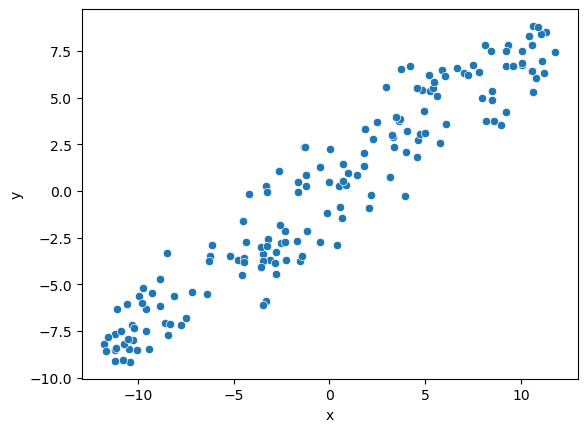

In [6]:
%matplotlib inline
from seaborn import scatterplot
scatterplot(data=tsne_plot_df, x='x', y='y', )